In [1]:
"""
Reimplementing in python Fig5_Terminal_constraints/scenario1_tc.m
"""
import numpy as np
import cvxpy as cp
import networkx as nx
from itertools import chain
from typing import List, Tuple
import matplotlib.pyplot as plt


In [2]:
# Network params
NETWORK = 4
LOCALITY = 3

# State dimensions
N = NETWORK   # number of pendulums
NS = 2        # number of states for each pendulum (theta, dtheta)
NA = 1        # number of actuators for each pendulum (dtheta)
NX = NS*N     # number of total states
NU = NA*N     # number of total actuators

# System params
m = 1         # [kg] mass of the pendulum
k = 1         # [N/m] spring constant
d = 3         # [Ns/m] damping constant
g = 10        # [m/s^2] gravity
l = 1         # [m] length of pendulum

# Scenario parameters
d = LOCALITY
x0 = 0.5 * np.ones((NX, 1))
T = 10

In [3]:
# Construct dynamic system matrices: dx = Ax + Bu
block_off_diag = np.array([[0,0], [k*l/m, d/m/l]])
block_diag_extra = np.array([[0, 1], [-g-k*l/m, -d/(m*l)]])
block_diag = np.array([[0, 1], [-g-2*k*l/m, -2*d/(m*l)]])

Ac = np.zeros((NX, NX))
Bc = np.zeros((NX, NU))
for j, i in enumerate(range(0, NX, 2)):
  Ac[i:i+2,i:i+2] = block_diag
  if j!=N-1:
    Ac[i:i+2,i+2:i+4] = block_off_diag
  if j!=0:
    Ac[i:i+2,i-2:i] = block_off_diag

  Bc[i:i+2, j] = np.array([0, 1])

In [4]:
# Discretize system
TS = .1       # [s] sampling time

A = np.eye(NX) + TS * Ac
B = TS * Bc

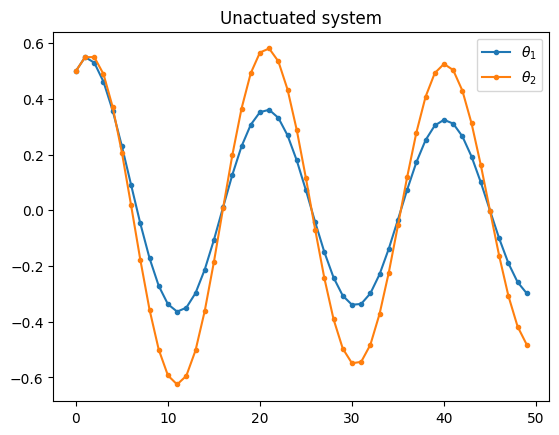

In [5]:
# scenario testing
Tsim = 50
x_history = np.zeros((Tsim, 1, NX))
x_history[0] = x0.T
for t in range(Tsim-1):
  x_history[t+1] = (A @ x_history[t].T).T

plt.plot(np.arange(0, Tsim), x_history[:, 0, 0], ".-", label="$\\theta_1$")
plt.plot(np.arange(0, Tsim), x_history[:, 0, 2], ".-", label="$\\theta_2$")
plt.title("Unactuated system")
plt.legend(loc="best")

In [6]:
# cost matrices for subsytem
Q = np.eye(NS)
S = np.eye(NA)
# cost matrix for entire system
Qq = np.eye(NX)
Ss = np.eye(NU)

Initial cost = 263.31169553381943


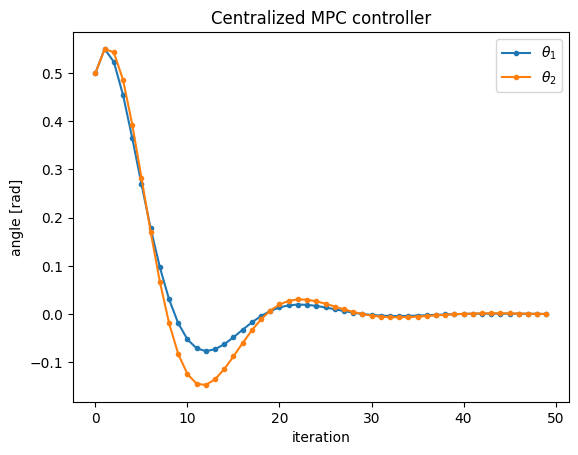

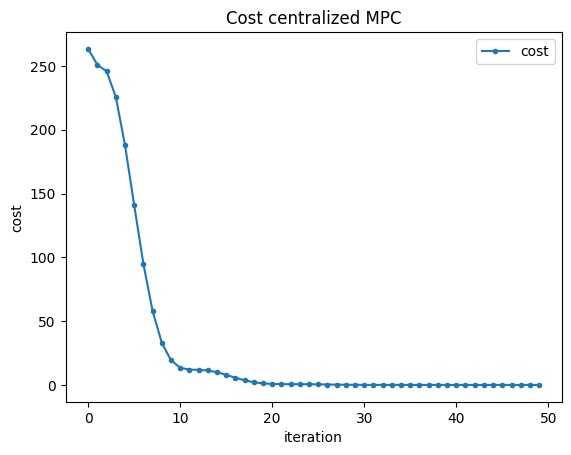

In [7]:
# centralized MPC
cost_mpc = np.zeros((Tsim))
x_mpc = np.zeros((Tsim, 1, NX))
x_mpc[0] = x0.T

for t in range(Tsim-1):
  # define optim variables
  x = cp.Variable((NX, T))
  u = cp.Variable((NU, T-1))
  # define objective
  objective = cp.Minimize(sum([cp.quad_form(x[:, i], Qq) + cp.quad_form(u[:, i], Ss) for i in range(T-1)]))
  # define constraints
  constraints = [x[:, 0] == x_mpc[t].T.squeeze()]  # initial condition
  constraints += [x[:, i+1] == A @ x[:, i] + B @ u[:, i] for i in range(T-1)]
  constraints += [x[:, -1] == np.zeros((NX))] # terminal constraint
  # solve
  prob = cp.Problem(objective, constraints)
  result = prob.solve()
  # store results
  x_mpc[t+1, 0, :] = x.value[:, 1]
  cost_mpc[t] = prob.value

plt.figure()
plt.plot(np.arange(0, Tsim), x_mpc[:, 0, 0], ".-", label="$\\theta_1$")
plt.plot(np.arange(0, Tsim), x_mpc[:, 0, 2], ".-", label="$\\theta_2$")
plt.xlabel("iteration")
plt.ylabel("angle [rad]")
plt.title("Centralized MPC controller")
plt.legend(loc="best")

plt.figure()
plt.plot(np.arange(0, Tsim), cost_mpc, ".-", label="cost")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost centralized MPC")
plt.legend(loc="best")

print(f"Initial cost = {cost_mpc[0]}")

In [8]:
# feasibility constraints (with terrminal constraint)
I = np.eye(NX*T)

Z = np.eye(NX*(T-1))                                                          # (NX*(T-1), NX*(T-1))
Z = np.concatenate((Z, np.zeros((NX*(T-1), NX))), axis=1)                     # (NX*(T-1), NX*T)
Z = np.concatenate((np.zeros((NX, NX*T)), Z), axis=0)                         # (NX*T, NX*T)
                                      
E1 = np.concatenate((np.eye(NX), np.zeros((NX*T, NX))))                       # (NX*(T+1), NX)
                                      
Aa = np.kron(np.eye(T, dtype=int), A)                                         # (NX*T, NX*T)
Bb = np.kron(np.eye(T, dtype=int), B)                                         # (NX*T, NU*T)
Bb = Bb[:, :-NU]                                                              # (NX*T, NU*(T-1))
                                      
IZA = I - Z @ Aa                                                              # (NX*T, NX*T)
IZA_terminal = np.concatenate((np.zeros((NX, NX*(T-1))), np.eye(NX)), axis=1) # (NX, NX*T)
IZA = np.concatenate((IZA, IZA_terminal), axis=0)                             # (NX*(T+1), NX*T)
ZB = -Z @ Bb                                                                  # (NX*T, NU*(T-1))
ZB = np.concatenate((ZB, np.zeros((NX, NU*(T-1)))), axis=0)                   # (NX*(T+1), NU*(T-1))
ZAB = np.concatenate((IZA, ZB), axis=1)                                       # (NX*(T+1), NX*T+NU*(T-1))

Initial cost = 263.31169554378005


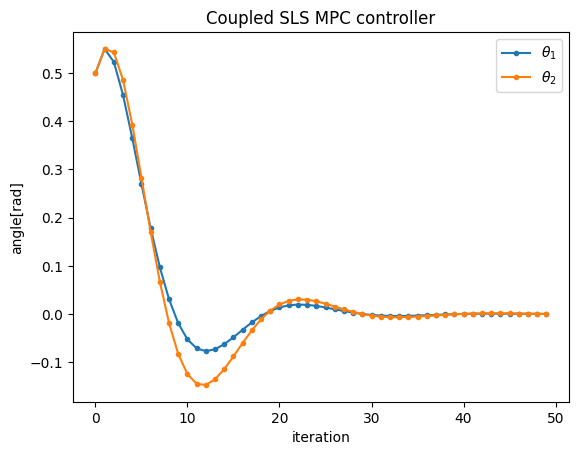

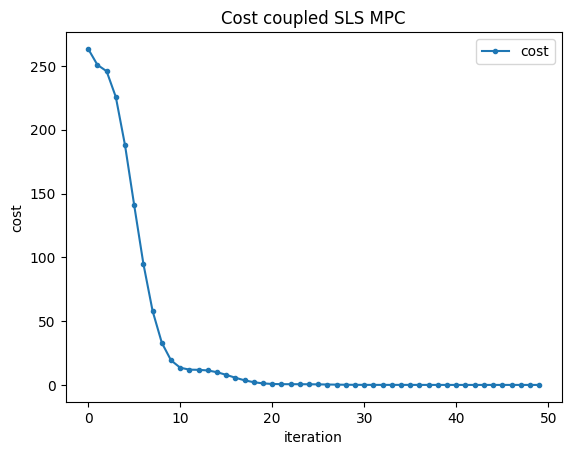

In [9]:
# Coupled SLS MPC: equation (10) in paper
cost_sls = np.zeros((Tsim))
x_sls = np.zeros((Tsim, 1, NX))
x_sls[0] = x0.T

for t in range(Tsim-1):
  # initial condition
  x_init = x_sls[t].T
  # decision variables
  x = cp.Variable((NX*T, 1))
  phi_u = cp.Variable((NU*(T-1), NX))
  # cost
  objective = cp.Minimize(sum([cp.quad_form(x[i*NX:(i+1)*NX], Qq) for i in range(T)]) + cp.quad_form(phi_u @ x_init, np.kron(np.eye(T-1),Ss)))
  # constraints
  constraints = [x[:NX] == x_init]
  constraints += [IZA @ x == ZB @ phi_u @ x_init + E1 @ x_init]
  # solve
  prob = cp.Problem(objective, constraints)
  result = prob.solve()
  # store results
  x_sls[t+1, 0, :] = x.value[NX:2*NX].squeeze()
  cost_sls[t] = prob.value

plt.plot(np.arange(0, Tsim), x_sls[:, 0, 0], ".-", label="$\\theta_1$")
plt.plot(np.arange(0, Tsim), x_sls[:, 0, 2], ".-", label="$\\theta_2$")
plt.xlabel("iteration")
plt.ylabel("angle[rad]")
plt.title("Coupled SLS MPC controller")
plt.legend(loc="best")

plt.figure()
plt.plot(np.arange(0, Tsim), cost_sls, ".-", label="cost")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost coupled SLS MPC")
plt.legend(loc="best")

print(f"Initial cost = {cost_sls[0]}")

In [10]:
def compute_edges() -> List[Tuple[int]]:
  """ Computes the edges for coupled subsystems """
  edges = []
  A0 = A != 0 # (NX, NX)
  B0 = B != 0 # (NX, NU)
  for i in range(N):
    for j in range(N):
      if A0[i*NS:(i+1)*NS, j*NS:(j+1)*NS].any() or B0[i*NS:(i+1)*NS, j*NA:(j+1)*NA].any():
        edges.append((j, i))
  return edges

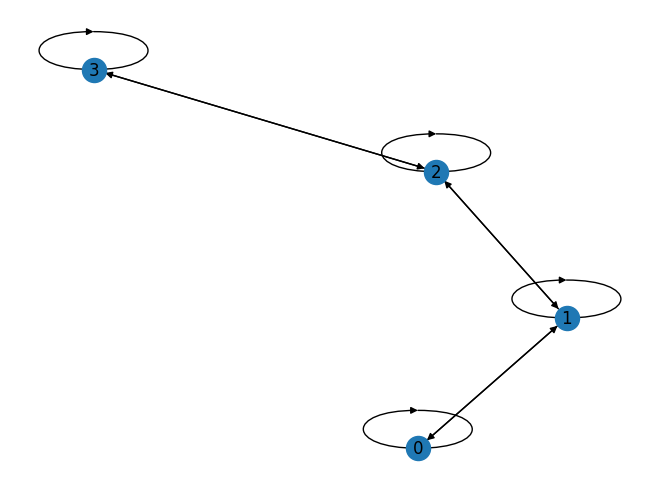

In [11]:
# compute network graph
G = nx.DiGraph()
edges = compute_edges()
G.add_edges_from(edges)

nx.draw(G, with_labels=True)
plt.show()

In [12]:
# compute d-local-outgoing sets
def compute_out(d: int) -> List[List[int]]:
  """ Returns matrix where matrix[i] = out_i(d) is the d-outgoing set for i """
  out = [[] for _ in range(N)]
  for i in range(N):
    for j in range(N):
      if nx.shortest_path_length(G, source=i, target=j) <= d:
        out[i].append(j)
  return out


In [13]:
# precompute indices of each subsystem
ids_x = [sorted(list(chain(*( range(sys+NS*i, NX*T, NX) for sys in range(NS))))) for i in range(N)]     # indices of states of subsytem i over horizon T
ids_u = [sorted(list(chain(*( range(sys+NA*i, NU*(T-1), NU) for sys in range(NA))))) for i in range(N)] # indices of actuators of subsytem i over horizon T

Initial cost = 263.31168948224195


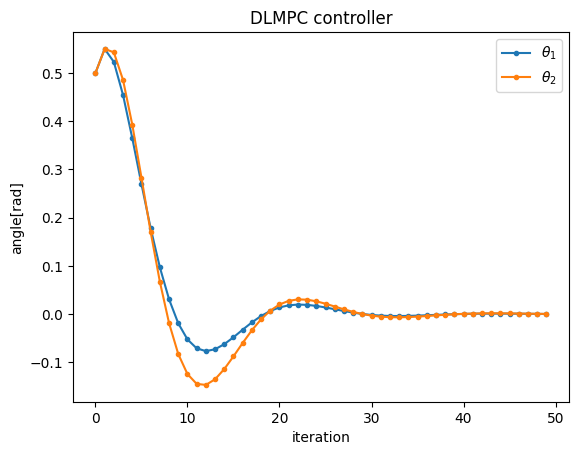

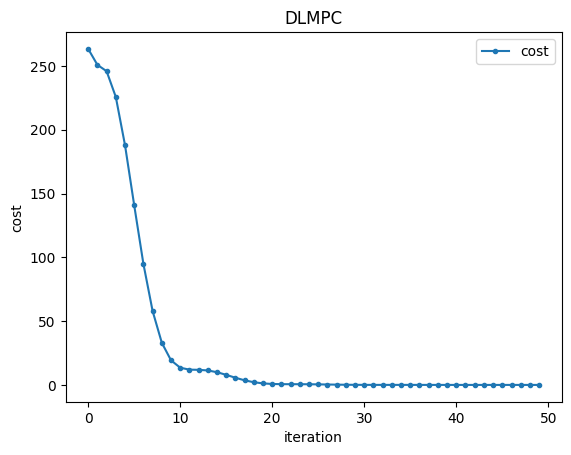

In [21]:
# DLMPC
cost_dlmpc = np.zeros((Tsim))
x_dlmpc = np.zeros((Tsim, 1, NX))
x_dlmpc[0] = x0.T
out_x = compute_out(LOCALITY)
out_u = compute_out(LOCALITY+1)

def f(i: int, x: cp.Variable, u: cp.Variable):
  """ cost function for each subsystem """
  return cp.quad_form(x, np.kron(np.eye(T),Q)) + cp.quad_form(u, np.kron(np.eye(T-1),S)) 

for t in range(Tsim-1):
  # initial condition
  x_init = x_dlmpc[t].T
  # define optim variables
  phi_x = cp.Variable((NX*T, NX*T))
  phi_u = cp.Variable((NU*(T-1), NX*T))
  # compute system solution
  x = phi_x[:, :NX] @ x_init  # (NX*T, 1)
  u = phi_u[:, :NX] @ x_init  # (NU*(T-1), 1)
  # objective
  objective = cp.Minimize(sum([f(i, x[ids_x[i],:], u[ids_u[i]]) for i in range(N)]))
  # feasibility and terminal constraints
  constraints = [IZA @ phi_x + ZB @ phi_u == np.concatenate((I, np.zeros((NX, NX*T))), axis=0)]
  # block lower triangular constraints
  # TODO: -2 and -3 (instead of -1 and -2) are due to the x being NX*T and u NU*(T-1)-> chnage to standard definition
  for i in range(T-2):
    constraints += [phi_x[NX*i:NX*(i+1), NX*(i+1):] == np.zeros((NX, NX*(T-i-1)))]
    if i < T-3:
      constraints += [phi_u[NU*i:NU*(i+1), NX*(i+1):] == np.zeros((NU, NX*(T-i-1)))]
  # locality constraints
  for i in range(N):
    for j in range(N):
      if i not in out_x[j]:
        constraints += [phi_x[ids_x[i]][:, ids_x[j]] == np.zeros((NS*T, NS*T))]
      if i not in out_u[j]:
        constraints += [phi_u[ids_u[i]][:, ids_x[j]] == np.zeros((NA*(T-1), NS*T))]
  # solve
  prob = cp.Problem(objective, constraints)
  result = prob.solve()
  # store results
  x_dlmpc[t+1, 0, :] = (phi_x.value[:, :NX] @ x_init)[NX:2*NX].squeeze()
  cost_dlmpc[t] = prob.value


plt.plot(np.arange(0, Tsim), x_dlmpc[:, 0, 0], ".-", label="$\\theta_1$")
plt.plot(np.arange(0, Tsim), x_dlmpc[:, 0, 2], ".-", label="$\\theta_2$")
plt.xlabel("iteration")
plt.ylabel("angle[rad]")
plt.title("DLMPC controller")
plt.legend(loc="best")

plt.figure()
plt.plot(np.arange(0, Tsim), cost_dlmpc, ".-", label="cost")
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("DLMPC")
plt.legend(loc="best")

print(f"Initial cost = {cost_dlmpc[0]}")

In [ ]:
arr= np.random.randint(10, size=(8, 8))

In [ ]:
print(arr)
for i in range(4):
  arr[2*i:2*(i+1), 2*(i+1):] = np.zeros((2, 8-2*(i+1)))
print(arr)